In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

## Data creation

function creation

In [2]:
def fill_large_contours(image, binary_mask, area_threshold):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # If there are no contours, return the original image
    if not contours:
        return image
    # Create a mask for all contours that are larger than the area threshold
    mask = np.zeros_like(binary_mask)
    for contour in contours:
        if cv2.contourArea(contour) > area_threshold:
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

In [3]:
def center_and_scale(img, mask, desired_size=None):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # Return original if no contours found

    # Calculate the combined bounding box around all contours
    min_x, min_y = img.shape[1], img.shape[0]
    max_x = max_y = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        min_x, min_y = min(x, min_x), min(y, min_y)
        max_x, max_y = max(x+w, max_x), max(y+h, max_y)
    
    # Crop the original image around the combined bounding box
    cropped_img = img[min_y:max_y, min_x:max_x]

    # If desired_size is not specified, use the original image size
    if desired_size is None:
        desired_size = img.shape

    # Scale the cropped image to the desired size
    scaled_img = cv2.resize(cropped_img, desired_size[::-1], interpolation=cv2.INTER_AREA)

    # Create a new blank image and place the scaled image in the center
    final_img = np.zeros_like(img)
    x_offset = (final_img.shape[1] - scaled_img.shape[1]) // 2
    y_offset = (final_img.shape[0] - scaled_img.shape[0]) // 2
    final_img[y_offset:y_offset+scaled_img.shape[0], x_offset:x_offset+scaled_img.shape[1]] = scaled_img

    return final_img

In [4]:
folder_path = '../datasets\Th24_PbRB-90kV-2_Rec\Th24_PbRB-90kV-2_Rec'

file_names = sorted(os.listdir(folder_path))      #cut off first and last 100 images to remove empty images
print(len(file_names))

2587


In [5]:
folder_path = '../datasets\Th24_PbRB-90kV-2_Rec\Th24_PbRB-90kV-2_Rec'
output_path = '../datasets/new_dataset_90kV/trainA'

file_names = sorted(os.listdir(folder_path))[150:-150]      #cut off first and last 150 images to remove empty images

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)



# Iterate through all files in the folder
for filename in tqdm(file_names, desc='Processing images'):

    file_path = os.path.join(folder_path, filename)
    processed_file_path = os.path.join(output_path, filename) # This should be the path where you save the processed image

    if os.path.isfile(file_path):
        # Load the image
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        # Check if the image is loaded properly
        if image is not None:

            # Apply Otsu's threshold
            _, binary_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Mask for areas where binary_image_otsu is white
            mask = binary_image_otsu == 255

            # Extract the values in the image corresponding to the mask
            values_under_mask = image[mask]

            # Apply a secondary threshold, for example, another Otsu's but only on the masked areas
            _, secondary_thresholded_values = cv2.threshold(values_under_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Flatten the secondary thresholded values to make it a 1-dimensional array
            secondary_thresholded_values = secondary_thresholded_values.flatten()
            # Initialize a final thresholded image
            final_thresholded_image = np.zeros_like(image)
            # Place the secondary thresholded values back into the masked area in the final image
            final_thresholded_image[mask] = secondary_thresholded_values

            # Use dilation to make the regions within the threshold bigger
            kernel = np.ones((3,3), np.uint8)
            #binary_image_otsu = cv2.morphologyEx(final_thresholded_image, cv2.MORPH_OPEN, kernel, iterations=2)
            binary_image_otsu = cv2.dilate(final_thresholded_image, kernel, iterations=1)

            contour_mask = fill_large_contours(image,binary_image_otsu, 1000)

            # Apply morphological opening to remove small artifacts
            kernel = np.ones((7, 7), np.uint8)
            opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel, iterations=2)

            # Apply morphological closing to smooth the outside
            closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)

            # Apply Gaussian blurring to the closing image
            blurred = cv2.GaussianBlur(closing, (15, 15), 0)

            new_contour_mask = fill_large_contours(image, blurred, 1000)

            result_img = cv2.bitwise_and(image, image, mask=new_contour_mask)
            result_img = center_and_scale(result_img, new_contour_mask)

            # Save the new image in the output folder with the same name
            cv2.imwrite(processed_file_path, result_img)

        else:
            print(f"Unable to load image: {filename}")


Processing images:   0%|          | 0/2287 [00:00<?, ?it/s]

Processing images: 100%|██████████| 2287/2287 [07:07<00:00,  5.34it/s]


## example showcase

In [2]:
import random
# Path to your directory containing images
folder_path = "../results/ct_hist_test/test_latest/images"

# List to hold the names of images that contain 'real'
real_image_names = [filename for filename in os.listdir(folder_path) if "real" in filename]

E9-5_13-03_50kV_rec00001726_real.png


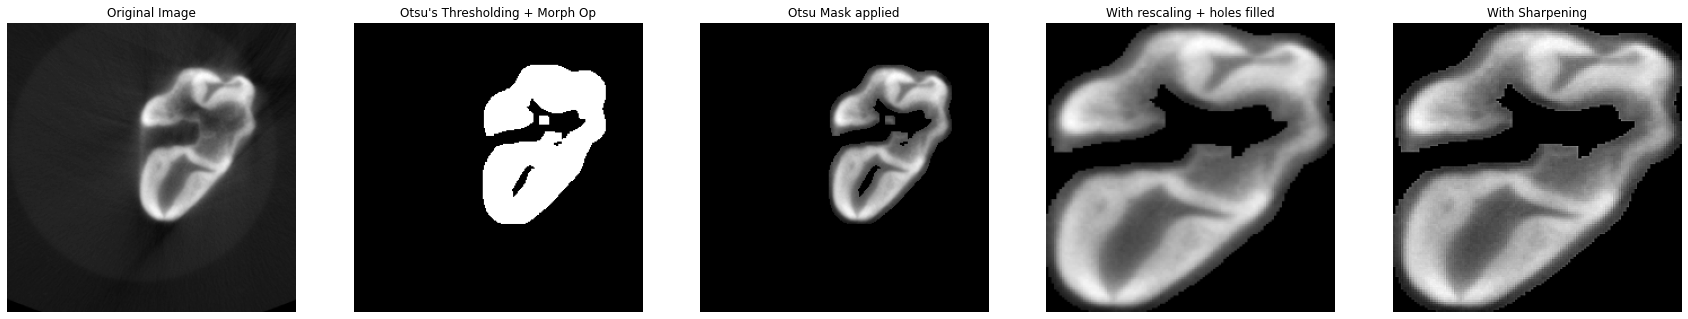

In [8]:
image_name = random.choice(real_image_names)
print(image_name)
real = cv2.imread(os.path.join('../results/ct_hist_test/test_latest/images/', image_name))
# Ensure that 'real' is a grayscale image
# If 'real' is a color image, convert it to grayscale first
if len(real.shape) == 3:
    preproc = cv2.cvtColor(real, cv2.COLOR_BGR2GRAY)
else:
    preproc = real.copy()

# Apply Otsu's threshold
_, binary_image_otsu = cv2.threshold(preproc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Use dilation to make the regions within the threshold bigger
kernel = np.ones((3,3), np.uint8)
binary_image_otsu = cv2.dilate(binary_image_otsu, kernel, iterations=3)

# Display the original and Otsu thresholded images
fig, ax = plt.subplots(1, 5, figsize=(30, 15))

# Original image
ax[0].imshow(preproc, cmap='gray')
ax[0].title.set_text('Original Image')
ax[0].axis('off')

# Otsu's thresholded image
ax[1].imshow(binary_image_otsu, cmap='gray')
ax[1].title.set_text(f"Otsu's Thresholding + Morph Op")
ax[1].axis('off')

# Apply the threshold to the original image to remove the background
new_img = preproc.copy()
new_img[binary_image_otsu == 0] = 0

# Display the image with the applied threshold
ax[2].imshow(new_img, cmap='gray')
ax[2].title.set_text(f"Otsu Mask applied")
ax[2].axis('off')

# Fill in the largest contour to keep details inside the area of interest
filled_image = fill_largest_contour(preproc, binary_image_otsu)

# Then apply your centering and scaling to the filled image
scaled_new_img = center_and_scale(filled_image, binary_image_otsu)
# Display the image with the applied threshold
ax[3].imshow(scaled_new_img, cmap='gray')
ax[3].title.set_text(f"With rescaling + holes filled")
ax[3].axis('off')

sharp_img = unsharp_mask(scaled_new_img)

ax[4].imshow(sharp_img, cmap='gray')
ax[4].title.set_text(f"With Sharpening")
ax[4].axis('off')


# Show the plot
plt.show()